# Exploratory Data Analysis (EDA) of the NOAA Severe Weather Data Inventory

In [1]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import pandas as pd
import numpy as np
import os, glob

c:\Users\timic\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# Commands to setup the notebook 
%load_ext autoreload
%autoreload 2

# Maximum number of lines to display
pd.options
pd.options.display.max_rows = 50

# Ignore warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [4]:
# SOURCED FROM KAGGLE!!!
# Import each dataset seperately
folder_path = '../storm_data'

def load_files(folder_path, pattern):
    """
    Looks up all CSV files matching 'pattern' in the folder path,
    loads them into DataFrames, then concatenates them.
    """
    # Get the list of matching files using glob
    file_paths = glob.glob(f"{folder_path}/{pattern}")
    
    # Use tqdm to show progress while loading files
    dataframes = []
    for file_path in tqdm(file_paths, desc=f"Loading {pattern}"):
        df = pd.read_csv(file_path, low_memory=False)
        if not df.empty:
            dataframes.append(df)
    
    if dataframes:
        return pd.concat(dataframes).reset_index(drop=True)
    else:
        return pd.DataFrame()  # Return empty DataFrame if no files match


# Keep 3 separate DataFrames (exactly as shown):
df_fatalities = load_files(folder_path, "*fatalities*.csv")
df_locations  = load_files(folder_path, "*locations*.csv")
df_details    = load_files(folder_path, "*details*.csv")

Loading *details*.csv: 100%|██████████| 75/75 [00:24<00:00,  3.12it/s]


In [5]:
# SOURCED FROM KAGGLE!!!
# Convert SOURCE to title case
df_details.SOURCE = df_details.SOURCE.str.title()

# List of acronyms that should be uppercase
ACRONYMS = ['Asos','Awos','Awss','Nws', 'C-Man','Raws','Shave','Snotel', 'Wlon']
for acronym in ACRONYMS:
    pattern = f'\\b{acronym}\\b'
    replacement = acronym.upper()
    df_details.SOURCE = df_details.SOURCE.str.replace(pattern, replacement, regex=True)

# One-off substitutions
source_substitutions = {
    'Arpt Equip(AWOS,ASOS)':'AWOS,ASOS,Mesonet,Etc',
    'Coastal Observing Station':'Coast Guard',
    'Cocorahs':'CoCoRaHS',
    'Coop Observer':'Cooperative Network Observer',
    'Coop Station':'Cooperative Network Observer',
    'Dept Of Highways':'Department Of Highways',
    'Fire Dept/Rescue Squad':'Fire Department/Rescue',
    'General Public':'Public',
    'Govt Official':'State Official',
    'Manual Input':'Unknown',
    'Meteorologist(Non NWS)' : 'Public',
    'NWS Employee(Off Duty)':'NWS Employee',
    'Npop':'Unknown',
    'Official NWS Obs.':'Official NWS Observations'
}

for original, replacement in source_substitutions.items():
    df_details.SOURCE = df_details.SOURCE.str.replace(original, replacement)

In [6]:
# SOURCED FROM KAGGLE!!!
event_substitution = {
    r'^HAIL.*' : 'Hail',
    r'^High Snow$' : 'Heavy Snow',
    r'^Hurricane$' : 'Hurricane (Typhoon)',
    r'^OTHER$' : 'Dust Devil',
    r'^THUNDERSTORM WIND.*' : 'Thunderstorm Wind',
    r'^TORNADO.*' : 'Tornado',
    r'^Volcanic Ashfall.*$' : 'Volcanic Ash'
    }
for original, replacement in event_substitution.items():
    df_details.EVENT_TYPE = df_details.EVENT_TYPE.str.replace( original, replacement, regex=True)

In [7]:
# SOURCED FROM KAGGLE!!!
timezone_substitutions = {
    "CDT" : "CST",
    "CSC" : "CST", # event was in Iowa
    'EDT' : 'EST',
    'GMT' : 'CST', # event was in Louisiana
    'GST' : 'ChST', # events were in Guam, which uses Chamorro Standard Time
    'MDT' : 'MST',
    'PDT' : 'PST',
    'SCT' : 'CST', # event was in Wisconsin
    }
unknown_timezones = {
    'HAWAII' : 'HST',
    'OKLAHOMA' : 'CST',
    'MASSACHUSETTS' : 'EST',
    'GEORGIA' : 'EST',
    'ILLINOIS' : 'CST'
    }

df_details.CZ_TIMEZONE = df_details.CZ_TIMEZONE.str.replace(r'-*\d*$','',regex=True).str.upper()

for original, replacement in timezone_substitutions.items():
    df_details.CZ_TIMEZONE = df_details.CZ_TIMEZONE.str.replace(original, replacement)
    
for index, row in df_details.query('CZ_TIMEZONE=="UNK"').iterrows():
    df_details.at[index, 'CZ_TIMEZONE'] = unknown_timezones.get(row.STATE, 'UNK')

In [8]:
# SOURCED FROM KAGGLE!!!
def create_datetime( df, prefix):
    df_components =  pd.to_datetime({
        'year' : df[ f"{prefix}YEARMONTH"] // 100,
        'month' : df[ f"{prefix}YEARMONTH"] % 100,
        'day' : df[ f"{prefix}DAY"],
        'hour' : df[ f"{prefix}TIME"]//100 ,
        'minute' : df[ f"{prefix}TIME"]%100,
        })
    return pd.to_datetime( df_components )

legacy = ['BEGIN_YEARMONTH', 'BEGIN_DAY', 'BEGIN_TIME', 'BEGIN_DATE_TIME']
legacy = legacy + ['END_YEARMONTH', 'END_DAY', 'END_TIME', 'END_DATE_TIME']
legacy = legacy + ['MONTH_NAME', 'YEAR']

df_details['BEGIN_DATETIME'] = create_datetime( df_details, 'BEGIN_')
df_details['END_DATETIME'] = create_datetime( df_details, 'END_')
df_details = df_details.drop(columns=legacy)

In [9]:
# SOURCED FROM KAGGLE!!!
def to_price( column ):
    price = column[ column.notnull()].astype('str').str.upper()
    
    valid_price = r'^[\d.]+[KMB]?$'
    price = price[ price.str.contains(valid_price, regex=True)]
    has_K = price.str.contains('K')
    has_M = price.str.contains('M')
    has_B = price.str.contains('B')
    price = price.str.replace(r'[KMB]','', regex=True).astype('float')
    
    scale = np.select([has_K, has_M, has_B], [1000, 1_000_000, 1_000_000_000], 1)
    return scale * price

df_details.DAMAGE_PROPERTY = to_price( df_details.DAMAGE_PROPERTY)
df_details.DAMAGE_CROPS = to_price( df_details.DAMAGE_CROPS)

In [10]:
# This fields have been converted to floats but should be integers
df_details.EPISODE_ID = df_details.EPISODE_ID.astype('Int64')
df_details.STATE_FIPS = df_details.STATE_FIPS.astype('Int64')

# Exploratory data analysis time!

In [11]:
# Keep only the first letter as a capital
df_details.columns   = df_details.columns.str.title()

In [12]:
print(f"Number of samples in the Dataset: {df_details.shape[0]}")
print(f"Nusmber of columns in the Dataset: {df_details.shape[1]}")
display(df_details.head())

Number of samples in the Dataset: 1941100
Nusmber of columns in the Dataset: 43


,Episode_Id,Event_Id,State,State_Fips,Event_Type,Cz_Type,Cz_Fips,Cz_Name,Wfo,Cz_Timezone,...,End_Location,Begin_Lat,Begin_Lon,End_Lat,End_Lon,Episode_Narrative,Event_Narrative,Data_Source,Begin_Datetime,End_Datetime
0,<NA>,10096222,OKLAHOMA,40,Tornado,C,149,WASHITA,NaN,CST,...,NaN,35.12,-99.20,35.17,-99.20,NaN,NaN,PUB,1950-04-28 14:45:00,1950-04-28 14:45:00
1,<NA>,10120412,TEXAS,48,Tornado,C,93,COMANCHE,NaN,CST,...,NaN,31.90,-98.60,31.73,-98.60,NaN,NaN,PUB,1950-04-29 15:30:00,1950-04-29 15:30:00
2,<NA>,10104927,PENNSYLVANIA,42,Tornado,C,77,LEHIGH,NaN,CST,...,NaN,40.58,-75.70,40.65,-75.47,NaN,NaN,PUB,1950-07-05 18:00:00,1950-07-05 18:00:00
3,<NA>,10104928,PENNSYLVANIA,42,Tornado,C,43,DAUPHIN,NaN,CST,...,NaN,40.60,-76.75,NaN,NaN,NaN,NaN,PUB,1950-07-05 18:30:00,1950-07-05 18:30:00
4,<NA>,10104929,PENNSYLVANIA,42,Tornado,C,39,CRAWFORD,NaN,CST,...,NaN,41.63,-79.68,NaN,NaN,NaN,NaN,PUB,1950-07-24 14:40:00,1950-07-24 14:40:00


In [13]:
# Check for missing values
missing_values_per_col = df_details.isna().sum()
percentage_missing_total = missing_values_per_col .sum()/ (df_details.size) * 100
print(f"There are exactly: {percentage_missing_total}% missing values in the dataset.")

# Find the 3 columns with the most missing values
top_3_missing_columns = np.array(missing_values_per_col.sort_values(ascending=False).index[:3])
print(f"The 3 columns with the most missing values are: {top_3_missing_columns[0]}, {top_3_missing_columns[1]} and {top_3_missing_columns[2]}.")

num_rows = df_details.shape[0]
percentage_missing_top_3 = np.array(missing_values_per_col.sort_values(ascending=False).values[:3]) / num_rows
print(f"The percentage of missing values in the top 3 columns are: {percentage_missing_top_3[0]:.2%}, {percentage_missing_top_3[1]:.2%} and {percentage_missing_top_3[2]:.2%}.")

There are exactly: 37.5393848848591% missing values in the dataset.
The 3 columns with the most missing values are: Category, Tor_Other_Cz_State and Tor_Other_Cz_Fips.
The percentage of missing values in the top 3 columns are: 99.97%, 99.82% and 99.82%.


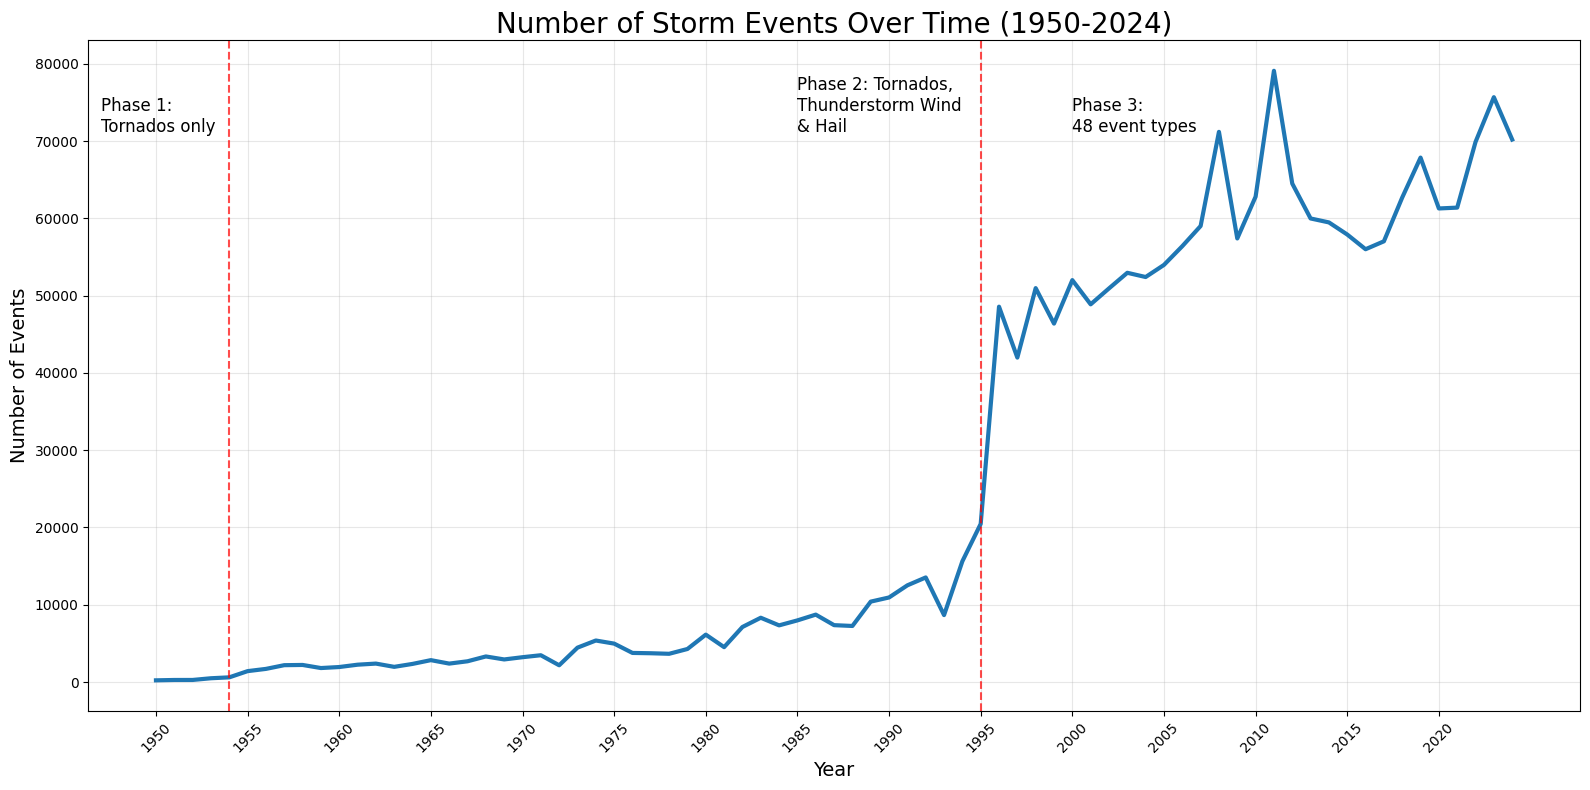

In [47]:
# Count events by year
events_by_year = df_details['Begin_Datetime'].dt.year.value_counts().sort_index()

# Create a line plot
plt.figure(figsize=(16, 8))
plt.plot(events_by_year.index, events_by_year.values, linewidth=3, color='#1f77b4')
plt.title('Number of Storm Events Over Time (1950-2024)', fontsize=20)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of Events', fontsize=14)
plt.grid(True, alpha=0.3)
plt.xticks(range(min(events_by_year.index), max(events_by_year.index)+1, 5), rotation=45)
plt.tight_layout()

# Add annotations for key periods
plt.axvline(x=1954, color='red', linestyle='--', alpha=0.7)
plt.axvline(x=1995, color='red', linestyle='--', alpha=0.7)
plt.text(1947, events_by_year.max()*0.9, 'Phase 1: \nTornados only', fontsize=12)
plt.text(1985, events_by_year.max()*0.9, 'Phase 2: Tornados, \nThunderstorm Wind \n& Hail', fontsize=12)
plt.text(2000, events_by_year.max()*0.9, 'Phase 3: \n48 event types', fontsize=12)

plt.savefig('Events_over_time.png')
plt.show()

In [15]:
state_counts = df_details['State'].value_counts()
state_counts = pd.DataFrame({'State': state_counts.index, 'Event_Count': state_counts.values})

In [16]:
# Create a mapping dictionary from uppercase state names to 2-letter codes
state_name_to_code = {
    'ALABAMA': 'AL', 'ALASKA': 'AK', 'ARIZONA': 'AZ', 'ARKANSAS': 'AR', 'CALIFORNIA': 'CA',
    'COLORADO': 'CO', 'CONNECTICUT': 'CT', 'DELAWARE': 'DE', 'FLORIDA': 'FL', 'GEORGIA': 'GA',
    'HAWAII': 'HI', 'IDAHO': 'ID', 'ILLINOIS': 'IL', 'INDIANA': 'IN', 'IOWA': 'IA',
    'KANSAS': 'KS', 'KENTUCKY': 'KY', 'LOUISIANA': 'LA', 'MAINE': 'ME', 'MARYLAND': 'MD',
    'MASSACHUSETTS': 'MA', 'MICHIGAN': 'MI', 'MINNESOTA': 'MN', 'MISSISSIPPI': 'MS', 'MISSOURI': 'MO',
    'MONTANA': 'MT', 'NEBRASKA': 'NE', 'NEVADA': 'NV', 'NEW HAMPSHIRE': 'NH', 'NEW JERSEY': 'NJ',
    'NEW MEXICO': 'NM', 'NEW YORK': 'NY', 'NORTH CAROLINA': 'NC', 'NORTH DAKOTA': 'ND', 'OHIO': 'OH',
    'OKLAHOMA': 'OK', 'OREGON': 'OR', 'PENNSYLVANIA': 'PA', 'RHODE ISLAND': 'RI', 'SOUTH CAROLINA': 'SC',
    'SOUTH DAKOTA': 'SD', 'TENNESSEE': 'TN', 'TEXAS': 'TX', 'UTAH': 'UT', 'VERMONT': 'VT',
    'VIRGINIA': 'VA', 'WASHINGTON': 'WA', 'WEST VIRGINIA': 'WV', 'WISCONSIN': 'WI', 'WYOMING': 'WY',
    'DISTRICT OF COLUMBIA': 'DC', 'AMERICAN SAMOA': 'AS', 'GUAM': 'GU', 'NORTHERN MARIANA ISLANDS': 'MP',
    'PUERTO RICO': 'PR', 'UNITED STATES VIRGIN ISLANDS': 'VI', 'U.S. VIRGIN ISLANDS': 'VI'
}

# Map the state names to codes
state_counts['State_Code'] = state_counts['State'].map(state_name_to_code)

# Create a choropleth map using the state codes
fig = px.choropleth(state_counts, 
                    locations='State_Code',  # Use the new column with state codes
                    locationmode='USA-states',
                    color='Event_Count',
                    scope='usa',
                    color_continuous_scale='Viridis',
                    title='Storm Events by State (1950-2020)')

fig.update_layout(
    title_font_size=20,
    coloraxis_colorbar=dict(
        title=dict(
            text='Number of Events',
            font=dict(size=14)
        )
    ),
    geo=dict(
        lakecolor='rgb(255, 255, 255)',
        showlakes=True
    ),
    height=600
)

fig.show()

In [17]:
state_counts.head()

,State,Event_Count,State_Code
0,TEXAS,156860,TX
1,KANSAS,90396,KS
2,OKLAHOMA,78486,OK
3,MISSOURI,69323,MO
4,IOWA,67200,IA


In [18]:
df_details['Year'] = pd.to_datetime(df_details['Begin_Datetime'],).dt.year
df_details['Year'].sample(5)

1695340    2021
512050     2001
243174     1996
585798     2003
1054343    2011
Name: Year, dtype: int32

In [19]:
# same map by years
years = [1950,1975,1995,2020]

for i in range(len(years)):
    state_counts = df_details[df_details['Year']==years[i]]['State'].value_counts()
    state_counts = pd.DataFrame({'State': state_counts.index, 'Event_Count': state_counts.values})
    # Map the state names to codes
    state_counts['State_Code'] = state_counts['State'].map(state_name_to_code)



    fig = px.choropleth(state_counts, 
                        locations='State_Code',  # Use the new column with state codes
                        locationmode='USA-states',
                        color='Event_Count',
                        scope='usa',
                        color_continuous_scale='Viridis',
                        title='Storm Events by State (' + str(years[i]) + ')')

    fig.update_layout(
        title_font_size=20,
        coloraxis_colorbar=dict(
            title=dict(
                text='Number of Events',
                font=dict(size=14)
            )
        ),
        geo=dict(
            lakecolor='rgb(255, 255, 255)',
            showlakes=True
        ),
        height=600
    )    
    fig.show()



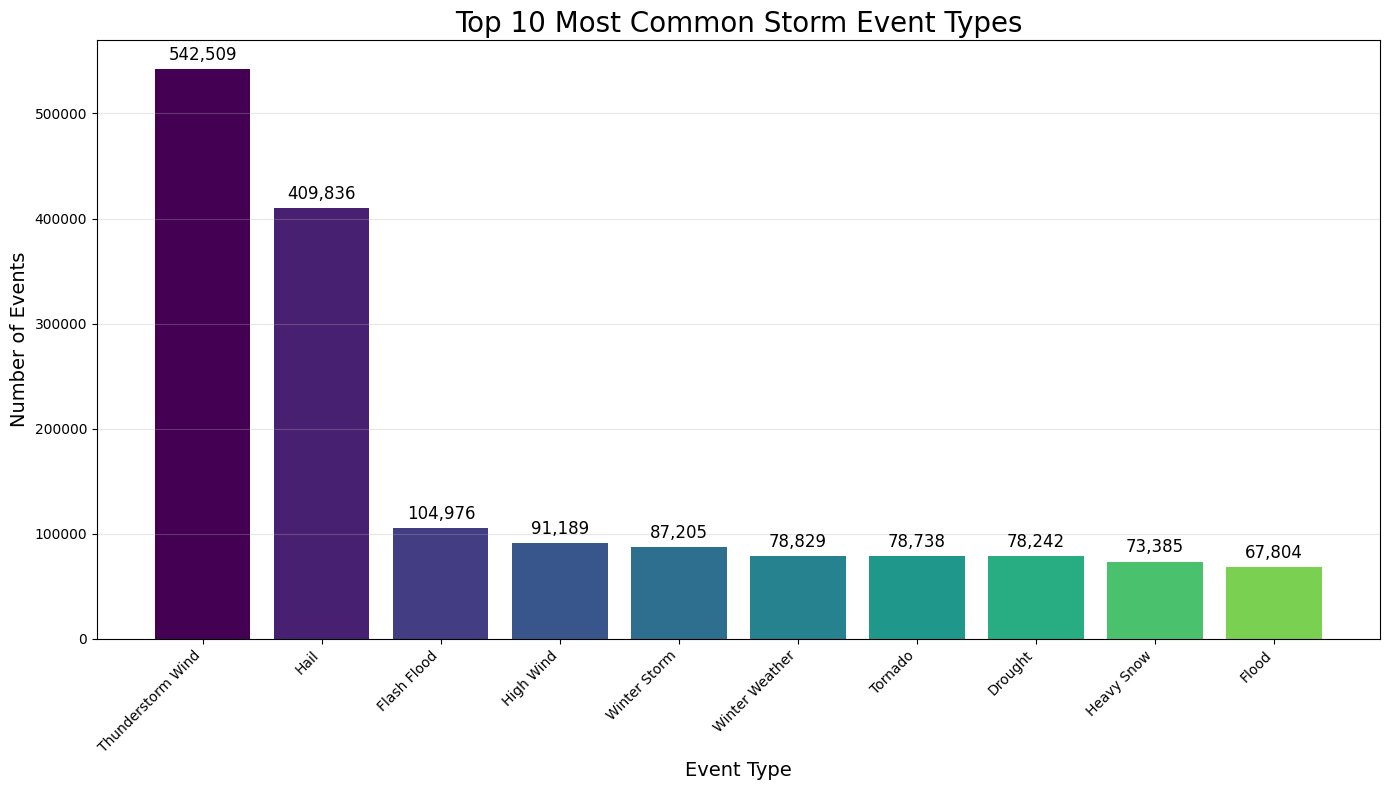

In [20]:
event_type_counts = df_details['Event_Type'].value_counts()
top_events = event_type_counts.head(10)

plt.figure(figsize=(14, 8))
bars = plt.bar(top_events.index, top_events.values, color=plt.cm.viridis(np.linspace(0, 0.8, len(top_events))))
plt.title('Top 10 Most Common Storm Event Types', fontsize=20)
plt.xlabel('Event Type', fontsize=14)
plt.ylabel('Number of Events', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

# Add count labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 5000,
             f'{height:,}', ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()

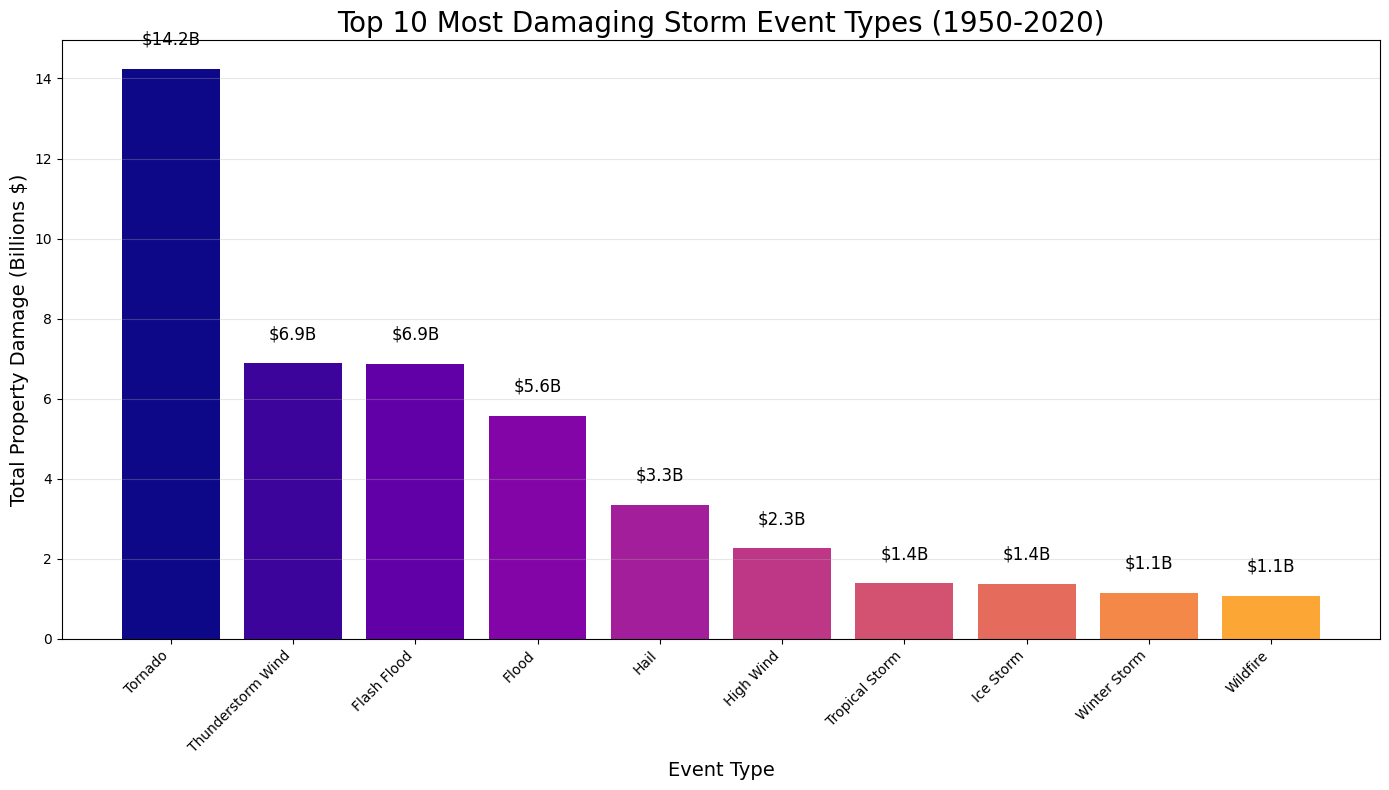

In [21]:
# Filter to events with damage info, remove extreme outliers for better visualization
damage_data = df_details[df_details['Damage_Property'] > 0].copy()
damage_data = damage_data[damage_data['Damage_Property'] < damage_data['Damage_Property'].quantile(0.99)]

# Sum damage by event type
damage_by_type = damage_data.groupby('Event_Type')['Damage_Property'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(14, 8))
bars = plt.bar(damage_by_type.index, damage_by_type.values / 1e9, color=plt.cm.plasma(np.linspace(0, 0.8, len(damage_by_type))))
plt.title('Top 10 Most Damaging Storm Event Types (1950-2020)', fontsize=20)
plt.xlabel('Event Type', fontsize=14)
plt.ylabel('Total Property Damage (Billions $)', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

# Add damage labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'${height:.1f}B', ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()

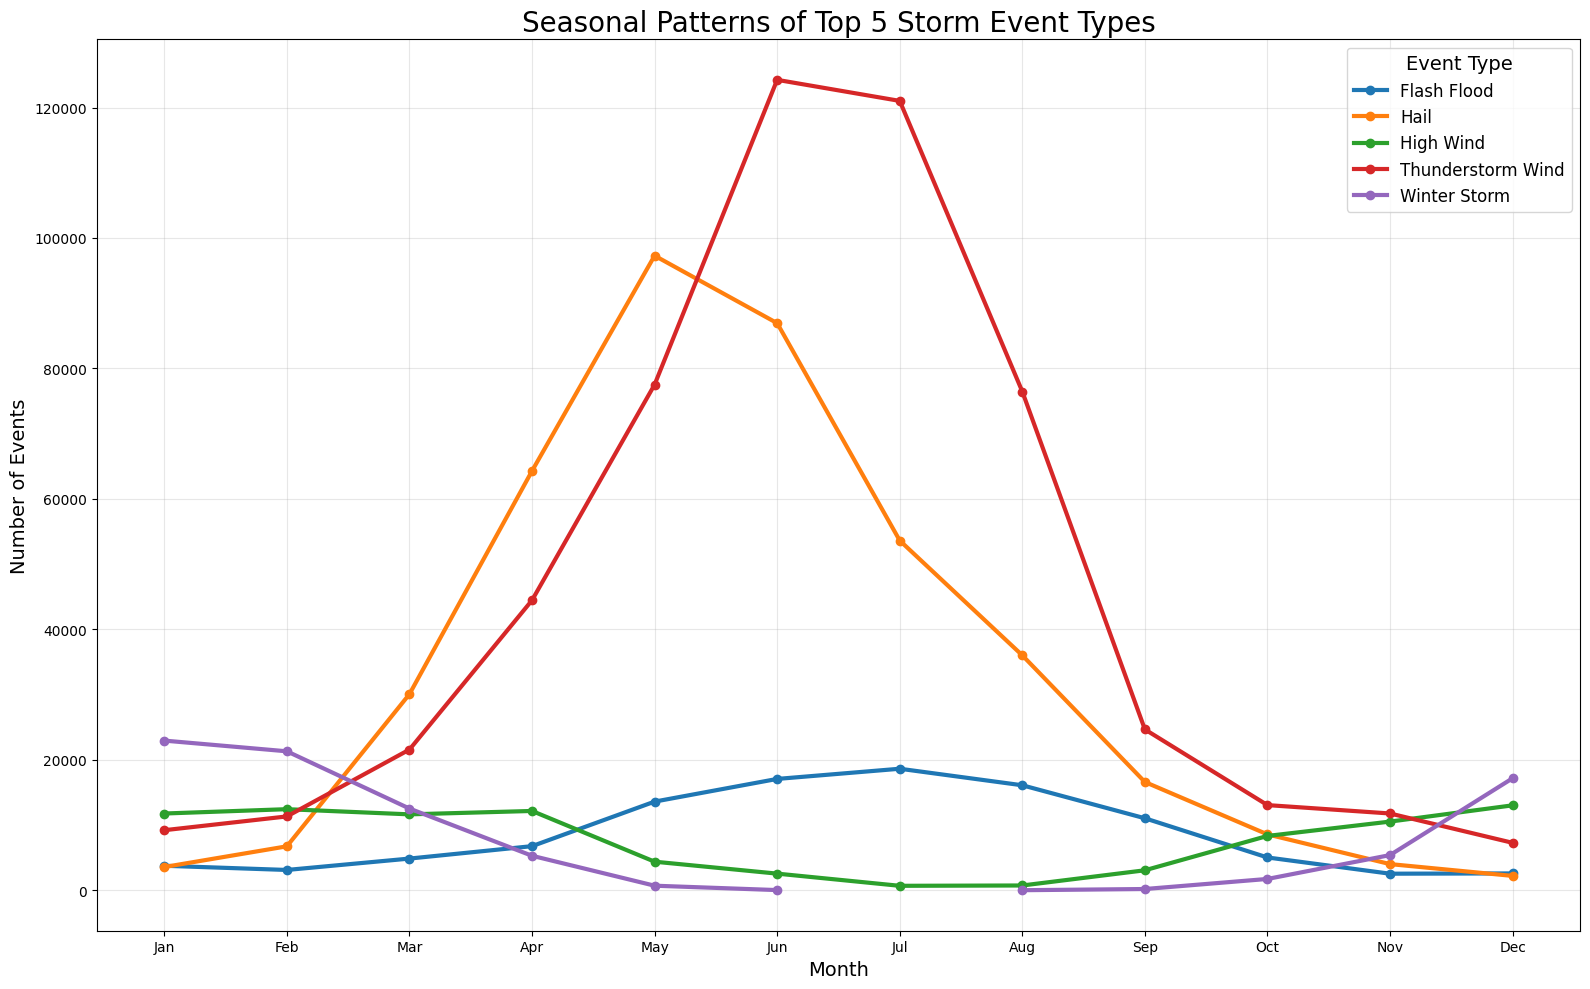

In [22]:
# Select top 5 event types for clearer visualization
top5_events = event_type_counts.head(5).index.tolist()
monthly_event_data = df_details[df_details['Event_Type'].isin(top5_events)]

# Count events by month and type(unstack pivots one of the two indices so that the series becomes a dataframe again)
monthly_counts = monthly_event_data.groupby([monthly_event_data['Begin_Datetime'].dt.month, 'Event_Type']).size().unstack()
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Plot
plt.figure(figsize=(16, 10))
for event_type in monthly_counts.columns:
    plt.plot(range(1, 13), monthly_counts[event_type], marker='o', linewidth=3, label=event_type)

plt.title('Seasonal Patterns of Top 5 Storm Event Types', fontsize=20)
plt.xlabel('Month', fontsize=14)
plt.ylabel('Number of Events', fontsize=14)
plt.xticks(range(1, 13), months)
plt.grid(True, alpha=0.3)
plt.legend(title='Event Type', fontsize=12, title_fontsize=14)
plt.tight_layout()
plt.show()

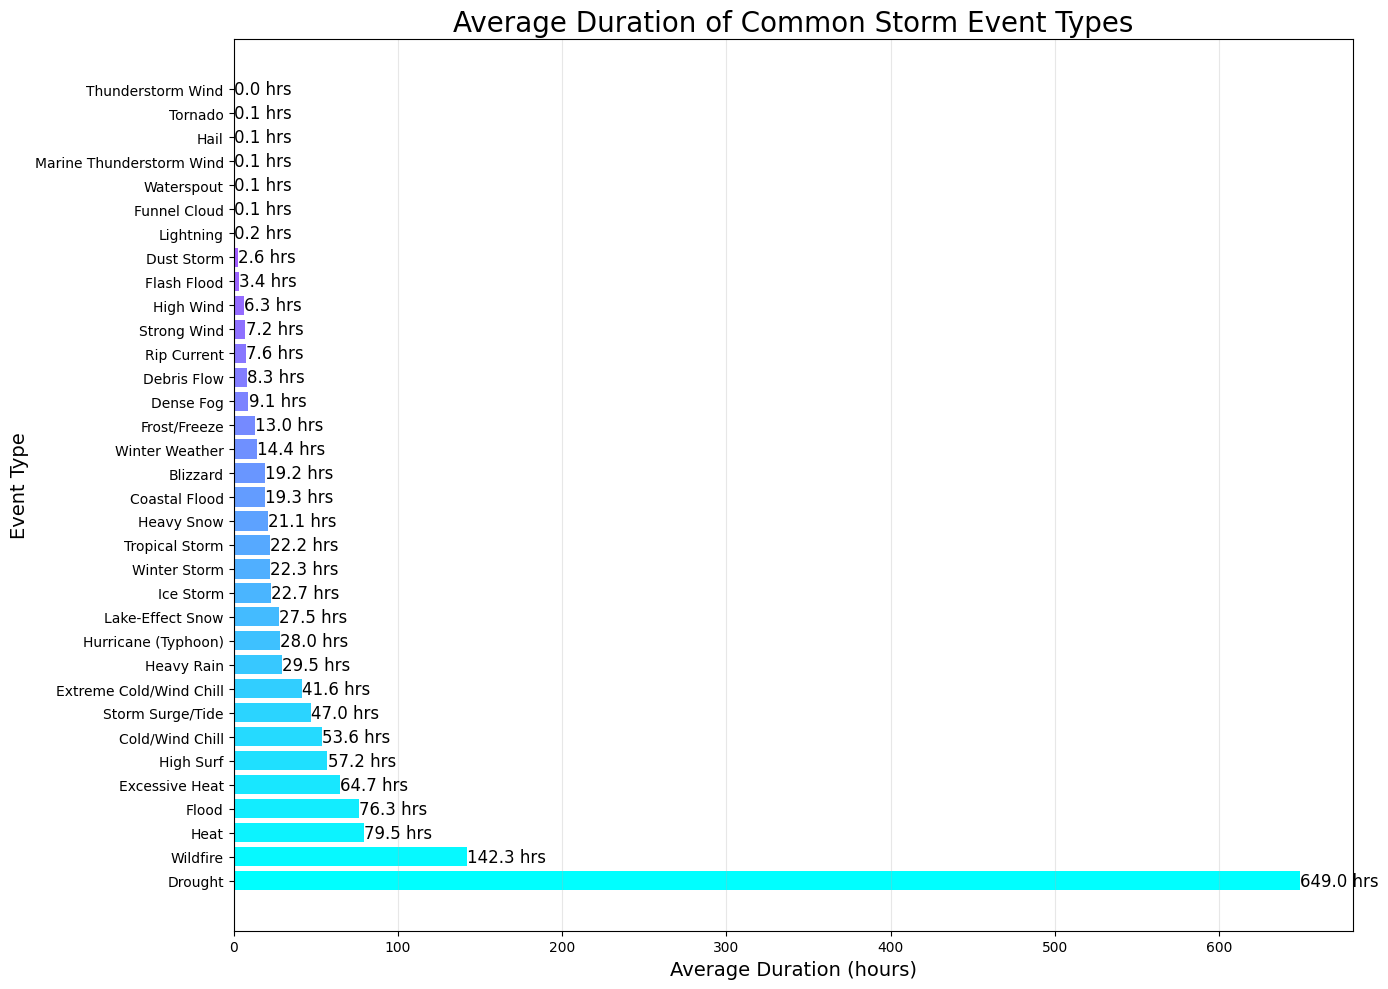

In [23]:
# Calculate event durations in hours and filter out extreme values
df_details['Duration_Hours'] = (df_details['End_Datetime'] - df_details['Begin_Datetime']).dt.total_seconds() / 3600
duration_data = df_details[df_details['Duration_Hours'] >= 0]

# Calculate average durations for common event types (with at least 1000 occurrences)
event_counts = df_details['Event_Type'].value_counts()
common_events = event_counts[event_counts >= 1000].index
duration_by_event = duration_data[duration_data['Event_Type'].isin(common_events)].groupby('Event_Type')['Duration_Hours'].mean().sort_values(ascending=False)

plt.figure(figsize=(14, 10))
bars = plt.barh(duration_by_event.index, duration_by_event.values, color=plt.cm.cool(np.linspace(0, 0.8, len(duration_by_event))))
plt.title('Average Duration of Common Storm Event Types', fontsize=20)
plt.xlabel('Average Duration (hours)', fontsize=14)
plt.ylabel('Event Type', fontsize=14)
plt.grid(axis='x', alpha=0.3)

# Add duration labels
for i, v in enumerate(duration_by_event.values):
    plt.text(v + 0.1, i, f'{v:.1f} hrs', va='center', fontsize=12)

plt.tight_layout()
plt.show()

# New stuff

In [42]:
df_details.sample()

,Episode_Id,Event_Id,State,State_Fips,Event_Type,Cz_Type,Cz_Fips,Cz_Name,Wfo,Cz_Timezone,...,Begin_Lon,End_Lat,End_Lon,Episode_Narrative,Event_Narrative,Data_Source,Begin_Datetime,End_Datetime,Year,Duration_Hours
944582,26941,157891,WYOMING,56,Winter Storm,Z,11,SOUTHEAST JOHNSON COUNTY,RIW,MST,...,NaN,NaN,NaN,Low pressure in Colorado produced a prolonged ...,NaN,CSV,2009-04-03 09:00:00,2009-04-04 18:00:00,2009,33.0


In [45]:
state_counts_by_year = df_details.groupby(["State", "Year"]).aggregate("size")

state_counts_by_year = pd.DataFrame({'State': state_counts_by_year.index.get_level_values(0),'year': state_counts_by_year.index.get_level_values(1), 'count': state_counts_by_year.values})

state_data_json = (
    state_counts_by_year
    .groupby("State")
    .apply(lambda g: g[["year", "count"]].to_dict(orient="records"))
    .to_dict()
)

import json
with open("state_event_counts.json", "w") as f:
    json.dump(state_data_json, f, indent=2)

C:\Users\timic\AppData\Local\Temp\ipykernel_5060\747583531.py:8: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



In [41]:
df_details["State"].unique().info()

AttributeError: 'numpy.ndarray' object has no attribute 'info'

# End of the Notebook